In [1]:
import tensorflow as tf
import numpy as np
import math
na = np.newaxis
import matplotlib.pyplot as plt
from matplotlib import gridspec

# import helper functions from utils.py:
from utils import tf_tril_indices, load_lookup_table, table_lookup_op_parallel, get_scp_samples, build_graph, build_eval_graph

# Planning:

- refactor code / make it more clear
- test on simple example and compare real / optimized distributions (define real dist-> sample data -> calc approx -> compare)
- test on real dataset

### TODOS:
- Fix Lookup Table
- Remove hardcoded num_inducing points (problem: using tf.shape(Z_ph)[0] returns a tensor, variables cannot be initialized with unknown shape)
- Define hyperparameters as variables and add two optimizers with var_lists to optimize with/without hyperparameters 

# 2d example

In [2]:
from scipy.stats import multivariate_normal

def double_blob(x):
    blob_1 = multivariate_normal.pdf(x, mean = [3, 3], cov=[[1, 0], [0, 1]])
    blob_2 = multivariate_normal.pdf(x, mean = [7, 7], cov=[[1, 0], [0, 1]])
    return (blob_1 + blob_2) * 10

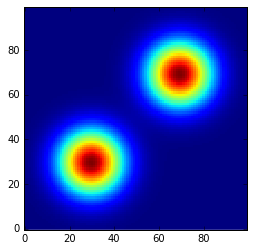

In [3]:
res = 100

xx, yy = np.meshgrid(np.linspace(0, 10, res), np.linspace(0, 10, res))

X = np.array([xx, yy]).transpose(1,2,0).reshape(res**2, 2)
vals = double_blob(X).reshape(res,res)

plt.imshow(vals, interpolation='none', origin='lower')
plt.show()

In [4]:
samples, _, _, _ = get_scp_samples(double_blob, np.array([[0, 10], [0,10]]), 10)

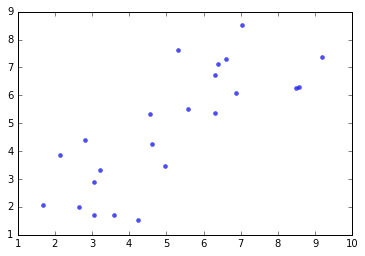

In [5]:
# sampled data:
plt.scatter(samples[:,0], samples[:,1], linewidth=0.1, alpha=.7)
plt.show()

# Variational Approximation

### 2D Parameter Learning

In [6]:
## ######## ##
# PARAMETERS #
## ######## ##
log_dir = 'logs'
max_iterations = 1000

ind_point_res = 7

# inducing point location
Zx = np.linspace(1, 9, ind_point_res)[:,na]
Zy = np.linspace(1, 9, ind_point_res)[:,na]

xx_ind_points, yy_ind_points = np.meshgrid(Zx, Zy)

Z = np.array([xx_ind_points, yy_ind_points]).transpose(1,2,0).reshape(ind_point_res**2, 2)

# X = np.random.rand(10,2)*10

## ######### ##
# BUILD GRAPH #
## ######### ##
tf.reset_default_graph()
lower_bound, merged, Z_ph, u_ph, X_ph, m, S, interesting_gradient, K_zz_inv = build_graph(Z.shape[0])

with tf.name_scope('optimization'):
    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(-lower_bound)
    

#inspected_op = tf.get_default_graph().get_tensor_by_name("KL-divergence/truediv:0")
#interesting_gradient = tf.gradients(lower_bound, [inspected_op])[0]

## ########## ##
# OPTIMIZATION #
## ########## ##
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter(log_dir, sess.graph)
    
    S_init_val = sess.run([S])
    # print(S_init_val)
    # print(np.all(np.linalg.eigvals(S_init_val) >= 0))
    
    for i in range(max_iterations):
        _, m_val, S_val, grad_val, summary,Kzz_inv = sess.run([train_step, m, S, interesting_gradient, merged,K_zz_inv], feed_dict={Z_ph:Z, u_ph:0.,X_ph:samples})
        writer.add_summary(summary, i)
        
        # print('------------')
        # print(S_val)
        # print(np.min(S_val))
        # print(np.max(S_val))
        # print(np.allclose(S_val, S_val.T))
        # print(np.all(np.linalg.eigvals(S_val) >= 0))
        
        #print(sess.run([S]))
        #print(sess.run([L_vech_grad]))

#print(m_val)       

#### 2D Evaluation

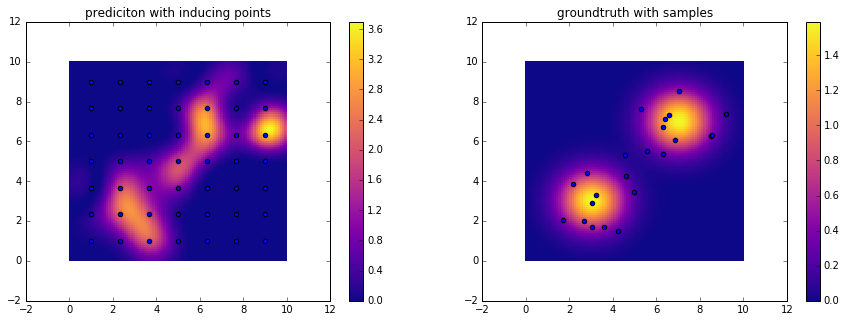

In [7]:
#evaluation grid
eval_res = 100
eval_x = np.linspace(0, 10, eval_res)[:,na]
eval_y = np.linspace(0, 10, eval_res)[:,na]
xx_eval, yy_eval = np.meshgrid(eval_x, eval_y)
eval_grid = np.array([xx_eval, yy_eval]).transpose(1,2,0).reshape(eval_res**2, 2)

#build graph
lam, lam_var, Z_ph,X_eval_ph, K_zz_inv_ph, S_ph, m_ph  = build_eval_graph()

#run session
with tf.Session() as sess:
    lam_vals, = sess.run([lam], feed_dict={Z_ph:Z, X_eval_ph:eval_grid,K_zz_inv_ph: Kzz_inv,S_ph:S_val,m_ph:m_val})

#plots
cmap = plt.get_cmap('plasma')

fig = plt.figure(figsize=(15,5)) 

ax0 = ax0 = plt.subplot(1,2,1)
im = ax0.pcolormesh(xx_eval, yy_eval, lam_vals.reshape(eval_res,eval_res), cmap=cmap)
fig.colorbar(im, ax=ax0)
ax0.set_title('prediciton with inducing points')
ax0.scatter(Z[:, 0], Z[:,1])

ax1 = ax0 = plt.subplot(1,2,2)
im1 = ax1.pcolormesh(xx, yy, vals, cmap=cmap)
fig.colorbar(im1, ax=ax1)
ax1.set_title('groundtruth with samples')
ax1.scatter(samples[:,0], samples[:,1])
            
plt.show()